# Searching through nested data with DocArray and subindices

---



Vector databases are great. They allow you to retrieve embedding vectors quickly and efficiently based on similarity, and thus form a key building block of many neural search applications.

But vector databases deal in, well, vectors, whereas you usually want to think about your data. When your data is simple, these two things are largely equivalent: Each vector represents one data point, and every data point is associated with one vector.
But the real world is messy, and that's where this isomorphism breaks down.

Luckily, there is a solution for that!

# The task: product search

In this notebook we will work through one such example: Our database consists of _listings_ of an online store. Each listing, in turn, contains multiple _images_ and a product _description_.

What we want to make this data searchable. Further, we want the user of our little search app to be able to use different modalities as their query input: They can search by text, by image, or by both at the same time.

To solve this problem, we need just one tool: [_DocArray_](https://docarray.jina.ai/?utm_medium=notebook-subindex).

Specifically we will heavily leverage three DocArray features:
1. [Multimodal documents](https://docarray.jina.ai/fundamentals/dataclass/?utm_medium=notebook-subindex), to model our data
2. [Subindices](https://docarray.jina.ai/fundamentals/documentarray/subindex/?utm_medium=notebook-subindex), to make our data points, and parts of those data points, searchable
3. [Document Stores](https://docarray.jina.ai/advanced/document-store/?utm_medium=notebook-subindex), to store our data on disk (and efficiently retrieve it from there)

We will so use [CLIP-as-Service](https://clip-as-service.jina.ai//?utm_medium=notebook-subindex) to create embeddings for our data, but you could use your favourite image and text embedding models instead.



# Data indexing

Before we actually index our data, let's take a look at what our data will have to look like to solve the task above.

- To search through the listing descriptions, each listing needs semantic _embedding_ that represents its description
- To search through listing images, each listing needs an embedding for every image in that listing
- To search through the listings as a whole, each listing needs an embedding that represents the listing in its entirety

So we'll be dealing with something like this:

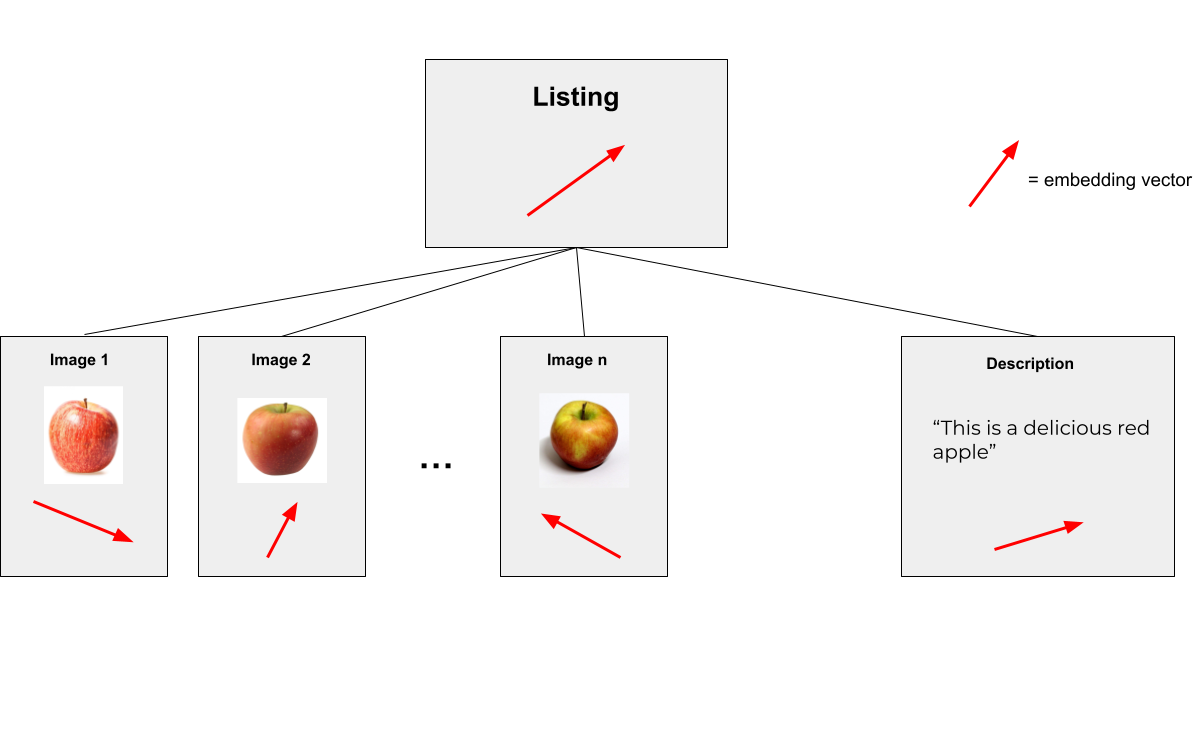

This kind of nested data structure can usually not be preserved when storing the embeddings in a vector database.

However, DocArray subindices allow us to do just that.

## Subindices explained

In DocArray, data is stored in the form of [`Document`s](https://docarray.jina.ai/fundamentals/document/?utm_medium=notebook-subindex) that are organized in a [`DocumentArray`](https://docarray.jina.ai/fundamentals/documentarray/?utm_medium=notebook-subindex). By default, a DocumentArray is an in-memory data structure, but it also natively supports Document Stores, which are (vector) database backends that can be used to persist data on disk.

Every DocumentArray represents one search index, so given a query, we can find elements contained in it. Once matching Documents are found, they can be loaded into memory.

Subindices allow this pattern to extend to nested data. Each subindex represents one nested level of the parent DocumentArray, such as `image` or `description`. If subindices are enabled, you can perform a search directly on that level, without loading all of your data into memory first - just like you do with the root level index.

Under the hood, each subindex creates a separate database index that stores the associated data independently from the other subindices or the root index.

## Data modelling

To model our domain data (the listings with images and descriptions), we use DocArray's multi-modal documents.

First we need to install DocArray (and clip-client, which we will use later to generate embeddings):

In [ ]:
!pip install docarray && pip install clip-client

Now we can actually model our data, which can be done using the dataclass and types provided by DocArray:

In [ ]:
from docarray import Document, DocumentArray, dataclass
from docarray.typing import Image, Text
from typing import List

@dataclass
class Listing:
  images: List[Image]
  description: Text

We will use this dataclass to organize our listings. Later on we will cast each `Listing` into a `Document`, the fundamental data object in DocArray.

All of our `Document`s will, in turn, be stored in a `DocumentArray`.

## Indexing our listings

Then, let's fill our model with data.

We first download some sample data and unzip it:

In [ ]:
!gdown 1AULyp1wMrSjV8uI5vksqJrqp-lr5oiPO
!unzip /content/listings.zip

Now that we have our data, we can store it as a list of `Listing`s:

In [ ]:
import os
data_path = '/content/listings/'
files = os.listdir(data_path)
image_file_extensions = ['jpg', 'jpeg', 'png']
listings = []
for listing in files:
  if os.path.isdir(os.path.join(data_path, listing)):
    listing_files = [os.path.join(data_path, listing, p) for p in os.listdir(os.path.join(data_path, listing))]
    image_uris = [image for image in listing_files if (image.split('.')[-1] in image_file_extensions)]
    with open(os.path.join(data_path, listing, 'description.txt'), 'r') as d:
      description = d.read()[:-1]  # remove trailing newline
    listings.append(Listing(images=image_uris, description=description))
print(listings)

At this point, our listings are simple dataclasses with no extra functionality.

So we cast our listings to `Document`, an operation tha will preserve the data format that we defined in the dataclass, and collect all Documents in a `DocumentArray`.

Additionally, we choose a storage backend for persisting our data on disk.
Here we use [SQLite](https://docarray.jina.ai/advanced/document-store/sqlite/?utm_medium=notebook-subindex) as a storage option, but any [Document Store](https://docarray.jina.ai/advanced/document-store/?utm_medium=notebook-subindex) would work: [ANNLite](https://docarray.jina.ai/advanced/document-store/annlite/?utm_medium=notebook-subindex), [Qdrant](https://docarray.jina.ai/advanced/document-store/qdrant/?utm_medium=notebook-subindex), [Weaviate](https://docarray.jina.ai/advanced/document-store/weaviate/?utm_medium=notebook-subindex), or [ElasticSearch](https://docarray.jina.ai/advanced/document-store/elasticsearch/?utm_medium=notebook-subindex).

Lastly, we create subindices for the nested data that we care about: images and descriptions.

In [ ]:
da = DocumentArray(
    [Document(l) for l in listings],  # cast listings to Document and store in DocumentArray
    storage='sqlite',  # use SQLite as vector database
    subindex_configs={'@.[images]': None, '@.[description]': None},  # set up subindices for image and description
)
da.summary()

If you are already familiar with DocArray then you know that strings like `'@.[image]'` and `'@.[description]'` can be used to [access our custom defined modalites](https://docarray.jina.ai/fundamentals/documentarray/access-elements/#index-by-nested-structure/?utm_medium=notebook-subindex) from the DocumentArray that we just created:

In [ ]:
print(f'-------- Image Documents: ---------')
da['@.[images]'].summary()
print(f'-------- Description Documents: ---------')
da['@.[description]'].summary()

In the code above we use these strings (_access paths_ as we like to call them) just to indicate what subindices we would like to create in our SQLite Document Store.

Note that we don't need to explicitly indicate an index for our overall listing embeddings, since the root level of a DocumentArray is always indexed.

After all this work, let's take the opportunity to look at the listings that we just indexed:

In [ ]:
for i, listing_doc in enumerate(da):
  print(f'\n-------- Listing no. {i+1}: ---------')
  listing_doc.images.plot_image_sprites()
  print(listing_doc.description.text)


So up until now we modelled our data, collected our listings, and stored them to disk using a SQLite database.

Next, we generate embeddings for our listings, and store those as well.

## Indexing the embedding vectors

The easiest way to get high quality embeddings is through [CLIP-as-Service](https://clip-as-service.jina.ai//?utm_medium=notebook-subindex), but any other embeddings would work just as well.

Here we create a separate embedding vector for each paragraph and for each image. For every listing we then use its associated image and paragraph embeddings to create a combined embedding for the entire listing.

Finally, we store all embeddings back to disk, together with their associated raw data.

In [ ]:
from clip_client import Client
import numpy as np

def set_root_embedding(doc):
  """Combines image embeddings and description embedding to create an embedding for the entire listing"""
  doc.embedding = np.concatenate([doc.images.embeddings.transpose().mean(axis=1), doc.description.embedding])
  return doc

c = Client('grpcs://api.clip.jina.ai:2096', credential={'Authorization': '317b9de1b1bfd7c65f8d54370af6ca72'})
# NOTE: To use the CAS server you need an auth token that you can get here:
# https://clip-as-service.jina.ai/hosting/by-jina/
# Of course you can also use any other service or model to obtain your embeddings!

for batch_da in da.batch(batch_size=64):  # load batches into memory
  batch_da['@.[images]'].embeddings = c.encode(batch_da['@.[images]']).embeddings  # generate image embeddings
  batch_da['@.[description]'].embeddings = c.encode(batch_da['@.[description]']).embeddings  # generate text embeddings
  batch_da.apply(set_root_embedding)  # combine to root-level embeddings
  with da:
    da[batch_da[:, 'id']] = batch_da  # store back to disk

There are two noteworthy things going on in this code snippet:
1. When accessing Documents from our SQLite Document Store, we load them into memory. We perform this actions in batches so that we don't run into out-of-memory issues.
2. `set_root_embedding()` works by averaging all image embeddigs and concatenating the result with the description embedding, for each listing. This is a straightforward and reasonable approach, but more sophisticated methods might make sense in practice. 

Finally, we can search through our data!

# Search on nested level

We first build a search that searches through a specific modality of our data, so either through the images or through the descriptions.

Depending on the input, we tackle that slightly differently.

## Image-to-Image search

Let's assume that our user provides an image as their input query.

We take that image and search for the most similar image among all listing images.

To do this, we first need to create an embedding for our query Document, and then we can leverage that embedding to find the most similar images in our database:

In [ ]:
query = Document(uri='/content/listings/query_apple.png').load_uri_to_image_tensor()
print(f'-------- Query image: ---------\n')
query.display()
query = c.encode([query])
most_similar_images = da.find(query, on='@.[images]')[0]  # search through image subindex using `on=`
print(f'\n-------- Top matches: ---------\n')
most_similar_images[:4].plot_image_sprites()
print(f'Similarity scores: {most_similar_images[:, "scores__cosine__value"]}')

## Text-to-Description search

We can do the same with an input text: We convert it to a Document and search for the most similar description:

In [ ]:
query = Document(text='tasty apple')
print(f'Query text: {query.text}')
query = c.encode([query])
most_similar_descriptions = da.find(query, on='@.[description]')[0]  # search through description subindex using `on=`
print(f'Top matches: {most_similar_descriptions.texts}')
print(f'Similarity scores: {most_similar_descriptions[:, "scores__cosine__value"]}')

## Text-to-Image and Image-to-Description search

And, thanks to the magic of clip embeddings, we can even use text to search for an image, and vice versa:

In [ ]:
# search image-to-text
query = Document(uri='/content/listings/query_apple.png').load_uri_to_image_tensor()
print(f'-------- Query image: ---------\n')
query.display()
query = c.encode([query])
most_similar_descriptions = da.find(query, on='@.[description]')[0]  # search through description subindex using `on=`
print(f'\n-------- Top image-to-text matches: ---------\n')
print(most_similar_descriptions.texts)
print(f'Similarity scores: {most_similar_descriptions[:, "scores__cosine__value"]}')

# search text-to-image
query = Document(text='apple')
print(f'-------- Query text: ---------\n')
print(query.text)
query = c.encode([query])
# TODO plot the query
most_similar_images = da.find(query, on='@.[images]')[0]  # search through image subindex using `on=`
print(f'\n-------- Top text-to-image matches: ---------\n')
most_similar_images[:4].plot_image_sprites()
# TODO plot the image

Once we have found the image that is closest to our query, we can retrieve the parent listing that it belongs to:

In [ ]:
print(f'\n-------- Top image-to-text match listings: ---------\n')
listing = da[most_similar_descriptions[:, 'parent_id']]
listing.summary()
print(f'\n-------- Top text-to-image match listings: ---------\n')
rid = da['@c'][most_similar_images[:, 'parent_id']][:, 'parent_id']
listing = da[rid]
listing.summary()

# Search on root level

If we have an input query that combines image and text data, we can perform a search directly on the listings (the root level of our data).

To do this, we first create a `Listing` out of the inputs, and then we apply the same embedding treatment to it as we did for the listings in our database.

Finally, we can use the query's root embedding to search through our stored embeddings:

In [ ]:
query = Document(Listing(images=['/content/listings/query_apple.png', '/content/listings/query_melon.png'], description='a tasty melon'))
print(f'------ Query listing ---------- \n')
query.images.plot_image_sprites()
print(f'Query description: {query.description.text}')

query.images.embeddings = c.encode(query.images).embeddings
query.description.embedding = c.encode([query.description]).embeddings[0]
query = set_root_embedding(query)

top_matching_listings = da.find(query)[0]
for i, d in enumerate(top_matching_listings[:4]):
  print(f'\n------ Top {i+1} match ---------- \n')
  d.images.plot_image_sprites()
  print(f'Listing dscription: {d.description.text}')
  print(f'Listing score: {d.scores["cosine"].value}')

Here the query isd actually a bit conflicting: It contains the image of an apple, and the image of a melon.

Still, our search did a reasonable job at finding mathching listings.

# Tying it all together

So far we've seen how we can:
- Index our data using subindices
- Take a query image and search through all images in our database
- Take a query description and search through all descriptions in our database
- Get the listing that correspons to the retrieved images/descriptions
- Take a query that consists of images and a description, and directly search through all listing in our database

Now we can take these building blocks and tie them together into a pipeline where a user can provide an arbitrary query and receive a sorted list of best matching listings.

In [ ]:
from typing import List, Optional

def _get_listings_from_descriptions(descriptions):
  return da[descriptions[:, 'parent_id']]


def _get_listings_from_images(descriptions):
  def _remove_duplicates(da):
    seen_ids = set()
    da_no_duplicates = DocumentArray()
    for d in da:
      if not d.id in seen_ids:
        da_no_duplicates.append(d)
      seen_ids.add(d.id)
    return da_no_duplicates

  listings = da[da['@c'][most_similar_images[:, 'parent_id']][:, 'parent_id']]
  return _remove_duplicates(listings)



def find_listings(query_image: Optional[str] = None, query_description: Optional[str] = None):
  if not query_image and not query_description:
    return []

  if query_image and query_description:  # search directly through listings
    query = Document(Listing(images=[query_image], description=query_description))
    query.images.embeddings = c.encode([query.images]).embeddings
    query.description.embedding = c.encode([query.description]).embeddings[0]
    query = set_root_embedding(query)
    return da.find(query)[0]

  if query_image:  # image-to-image search
    query = Document(uri=query_image).load_uri_to_image_tensor()
    query = c.encode([query])
    return _get_listings_from_images(da.find(query, on='@.[images]')[0])

  if query_description:  # text-to-description search
    query = Document(text=query_description)
    query = c.encode([query])
    return _get_listings_from_descriptions(da.find(query, on='@.[description]')[0])

In [ ]:
combined_results = find_listings(query_image='/content/listings/query_melon.png', query_description='tasty watermelon')
image_results = find_listings(query_image='/content/listings/query_melon.png')
description_results = find_listings(query_description='tasty watermelon')

for name, results in zip(['combined', 'image', 'description'], [combined_results, image_results, description_results]):
  print(f'\n----------- Top matches for {name} search: -----------')
  for i, d in enumerate(results[:4]):
    print(f'\n------ Top {i+1} match ---------- \n')
    d.images.plot_image_sprites()
    print(f'Listing dscription: {d.description.text}')
    print(f'Listing score: {d.scores["cosine"].value}')

# Next steps

Congrats, you just built a serach app for nested data leveraging subindices!

There are few thing you could look into next:

- Read the docs about [subindices](https://docarray.jina.ai/fundamentals/documentarray/subindex/?utm_medium=notebook-subindex)
- Learn more about [multi-modality support](https://docarray.jina.ai/fundamentals/dataclass/?utm_medium=notebook-subindex) in DocArray
- Find out about the embedding service that we used in this notebook, [CLIP-as-Service](https://clip-as-service.jina.ai//?utm_medium=notebook-subindex)
- Easily deploy, scale and serve your search app using [Jina](https://docs.jina.ai//?utm_medium=notebook-subindex)